In [ ]:
!pip install pyspark

     |████████████████████████████████| 212.4 MB 66 kB/s 
     |████████████████████████████████| 198 kB 67.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=e37e96b1d01db1c07c6261b6d042f045ca5b2bb5b51afa5801606b6161690868
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import io
#from google.colab import drive 

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
import pyspark.sql.types
spark=SparkSession.builder.appName('Train').getOrCreate()
#spark2=SparkSession.builder.appName('Train2').getOrCreate()

In [ ]:
df_train = spark.read.format('csv').option('delimiter',';').load('gdrive/My Drive/BERT/train.txt')
df_train=df_train.withColumnRenamed("_c0","text")
df_train=df_train.withColumnRenamed("_c1","emotion")
#df_train.show()

In [ ]:
df_val = spark.read.format('csv').option('delimiter',';').load('gdrive/My Drive/BERT/val.txt')
df_val=df_val.withColumnRenamed("_c0","text")
df_val=df_val.withColumnRenamed("_c1","emotion")
#df_val.show()

In [ ]:
df_test = spark.read.format('csv').option('delimiter',';').load('gdrive/My Drive/BERT/test.txt')
df_test=df_test.withColumnRenamed("_c0","text")
df_test=df_test.withColumnRenamed("_c1","emotion")
#df_val.show()

In [ ]:
df_train.groupBy("emotion").count().sort("count",ascending=True).show()
df_train.count()

+--------+-----+
| emotion|count|
+--------+-----+
|surprise|  572|
|    love| 1304|
|    fear| 1937|
|   anger| 2159|
| sadness| 4666|
|     joy| 5362|
+--------+-----+



16000

In [ ]:
emotions = ['surprise','love','fear','anger','sadness','joy']
emotion_count=[]

emomax = int(0)
for emo in emotions:
  for emoo in emotions:
    if df_train[df_train['emotion']==emoo].count() > df_train[df_train['emotion']==emo].count():
      emomax = df_train[df_train['emotion']==emoo].count()
  num_emo = df_train[df_train['emotion']==emo].count()
  emotion_count.append(emomax/num_emo)

In [ ]:
emotions_ratios = [int(np.round(x)) for x in emotion_count]

In [ ]:
from pyspark.sql.functions import col, explode, array, lit

In [ ]:
index = 0
for emotion in emotions: #scegli emozione 
  df_emo = df_train.filter(col('emotion')==emotion)
  print(index,emotion)
  a = range(emotions_ratios[index]-1)
  df_emo_od = df_emo.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
  df_train = df_train.union(df_emo_od)
  index+=1

0 surprise
1 love
2 fear
3 anger
4 sadness
5 joy


In [ ]:
df_train.groupBy("emotion").count().sort("count",ascending=True).show()
df_train.count()

+--------+-----+
| emotion|count|
+--------+-----+
|   anger| 4318|
| sadness| 4666|
|surprise| 5148|
|    love| 5216|
|     joy| 5362|
|    fear| 5811|
+--------+-----+



30521

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [ ]:
def ohe_encoder(df1):
  indexer = StringIndexer(inputCol="emotion", outputCol="emo_ohe2").fit(df1)
  df1 = indexer.transform(df1)
  ohe = OneHotEncoder()
  ohe.setInputCols(["emo_ohe2"])
  ohe.setOutputCols(["emo_ohe"])
  model = ohe.fit(df1)
  df1 = model.transform(df1)
  df1 = df1.drop('emotion')
  df1 = df1.drop('emo_ohe2')
  return df1

In [ ]:
#df_train = ohe_encoder(df_train)
#df_val = ohe_encoder(df_val)
#df_test = ohe_encoder(df_test)

In [ ]:
from pyspark.ml.linalg import Vectors

In [ ]:
df_train.show()

+--------------------+--------+
|                text| emotion|
+--------------------+--------+
|i didnt feel humi...| sadness|
|i can go from fee...| sadness|
|im grabbing a min...|   anger|
|i am ever feeling...|    love|
|i am feeling grouchy|   anger|
|ive been feeling ...| sadness|
|ive been taking o...|surprise|
|i feel as confuse...|    fear|
|i have been with ...|     joy|
| i feel romantic too|    love|
|i feel like i hav...| sadness|
|i do feel that ru...|     joy|
|i think it s the ...|   anger|
|i feel low energy...| sadness|
|i have immense sy...|     joy|
|i do not feel rea...|     joy|
|i didnt really fe...| sadness|
|i feel pretty pat...| sadness|
|i started feeling...| sadness|
|i now feel compro...|    fear|
+--------------------+--------+
only showing top 20 rows



In [ ]:
train_data = df_train.toPandas()
print(train_data)

                                                    text  emotion
0                                i didnt feel humiliated  sadness
1      i can go from feeling so hopeless to so damned...  sadness
2       im grabbing a minute to post i feel greedy wrong    anger
3      i am ever feeling nostalgic about the fireplac...     love
4                                   i am feeling grouchy    anger
...                                                  ...      ...
30516          i have a feeling im going to be heartless    anger
30517  i often find my self feeling offended myself w...    anger
30518  i took a minute to appreciate the trees around...    anger
30519  i moved away he said something that made me fe...    anger
30520  i feel like this was such a rude comment and i...    anger

[30521 rows x 2 columns]


In [ ]:
val_data = df_val.toPandas()
print(train_data)

                                                    text  emotion
0                                i didnt feel humiliated  sadness
1      i can go from feeling so hopeless to so damned...  sadness
2       im grabbing a minute to post i feel greedy wrong    anger
3      i am ever feeling nostalgic about the fireplac...     love
4                                   i am feeling grouchy    anger
...                                                  ...      ...
30516          i have a feeling im going to be heartless    anger
30517  i often find my self feeling offended myself w...    anger
30518  i took a minute to appreciate the trees around...    anger
30519  i moved away he said something that made me fe...    anger
30520  i feel like this was such a rude comment and i...    anger

[30521 rows x 2 columns]


In [ ]:
test_data = df_test.toPandas()
print(train_data)

                                                    text  emotion
0                                i didnt feel humiliated  sadness
1      i can go from feeling so hopeless to so damned...  sadness
2       im grabbing a minute to post i feel greedy wrong    anger
3      i am ever feeling nostalgic about the fireplac...     love
4                                   i am feeling grouchy    anger
...                                                  ...      ...
30516          i have a feeling im going to be heartless    anger
30517  i often find my self feeling offended myself w...    anger
30518  i took a minute to appreciate the trees around...    anger
30519  i moved away he said something that made me fe...    anger
30520  i feel like this was such a rude comment and i...    anger

[30521 rows x 2 columns]


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30521 entries, 0 to 30520
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     30521 non-null  object
 1   emotion  30521 non-null  object
dtypes: object(2)
memory usage: 477.0+ KB


In [ ]:
train_data.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
y_train=np.array(train_data['emotion'])
y_test=np.array(test_data['emotion'])
y_val=np.array(val_data['emotion'])

In [ ]:
train_data['emotion'].value_counts()

fear        5811
joy         5362
love        5216
surprise    5148
sadness     4666
anger       4318
Name: emotion, dtype: int64

In [ ]:
# Build the model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
# Train the model using the training data
model.fit(train_data.text, train_data.emotion)
# Predict the categories of the test data
y_pred = model.predict(test_data.text)

In [ ]:
y_test

array(['sadness', 'sadness', 'sadness', ..., 'joy', 'joy', 'fear'],
      dtype=object)

In [ ]:
conf_matrix=confusion_matrix(y_pred,y_test)

In [ ]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

       anger       0.64      0.87      0.74       203
        fear       0.87      0.57      0.69       342
         joy       0.81      0.89      0.85       632
        love       0.82      0.50      0.62       260
     sadness       0.74      0.96      0.83       447
    surprise       0.74      0.42      0.54       116

    accuracy                           0.77      2000
   macro avg       0.77      0.70      0.71      2000
weighted avg       0.78      0.77      0.76      2000



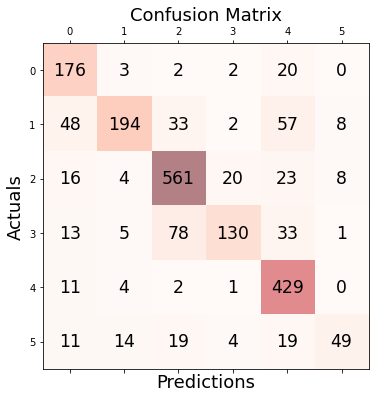

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()